In [19]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.manager import SwarmManager
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo

from backtester.positionsizing import PositionSizingBase
import pandas as pd
import numpy as np
import scipy

In [21]:

from strategies.strategy_macross_with_trail import StrategyMACrossTrail

## Script settings

In [22]:
STRATEGY_CONTEXT = {
    'strategy': { 
        'class': StrategyMACrossTrail,
        'exo_name': 'strategy_270225',
        'direction': -1,
        'opt_params': [
                #OptParam(name, default_value, min_value, max_value, step)
                OptParamArray('Direction', [1, -1]),
                OptParam('SlowMAPeriod', 20, 10, 30, 2),
                OptParam('FastMAPeriod', 2, 2, 20, 1),
                OptParam('MedianPeriod', 5, 5, 20, 3)
            ],
    },
    'swarm': {
        'members_count': 5,
        'ranking_function': SwarmRanker.highestreturns_14days_with_slopefilter,
        'rebalance_time_function': SwarmRebalance.every_monday,   
        
        #'global_filter_function': SwarmFilter.swingpoint_threshold,
        'global_filter_params': {
            'up_factor': 3.0,
            'down_factor': 10.0,
            'period': 5,
        },
        #'global_filter_function': filter_rolling_mean,
        #'global_filter_params': {
        #    'ma_period': 100,
        #}
    },
    'costs':{
        'manager': CostsManagerEXOFixed,
        'context': {
            'costs_options': 3.0,
            'costs_futures': 3.0,
        }
    }
}

# Backtest class based strategy

In [23]:
smgr = SwarmManager(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

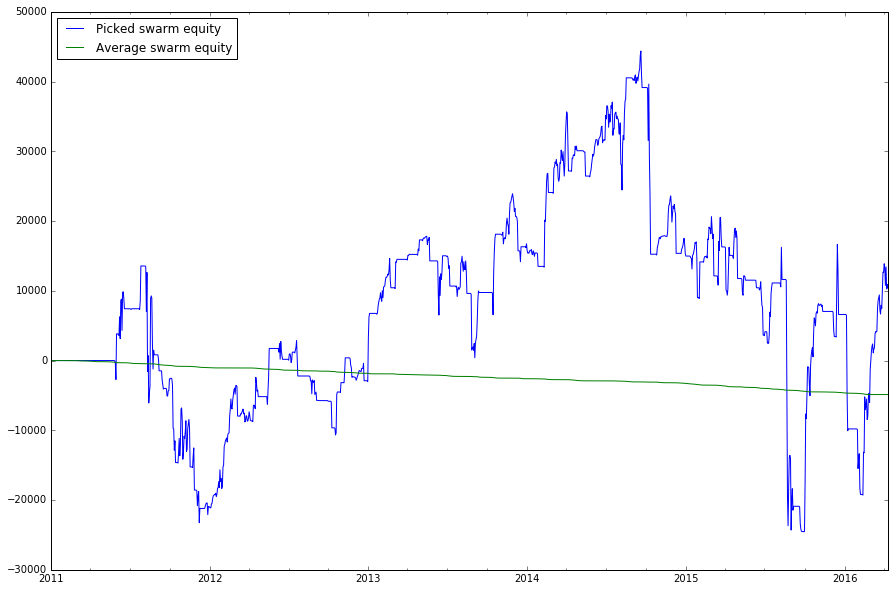

In [24]:
figsize(15,10)
smgr.swarm_picked.sum(axis=1).plot(label='Picked swarm equity');
(smgr.swarm_avg).plot(label='Average swarm equity');
legend(loc=2);


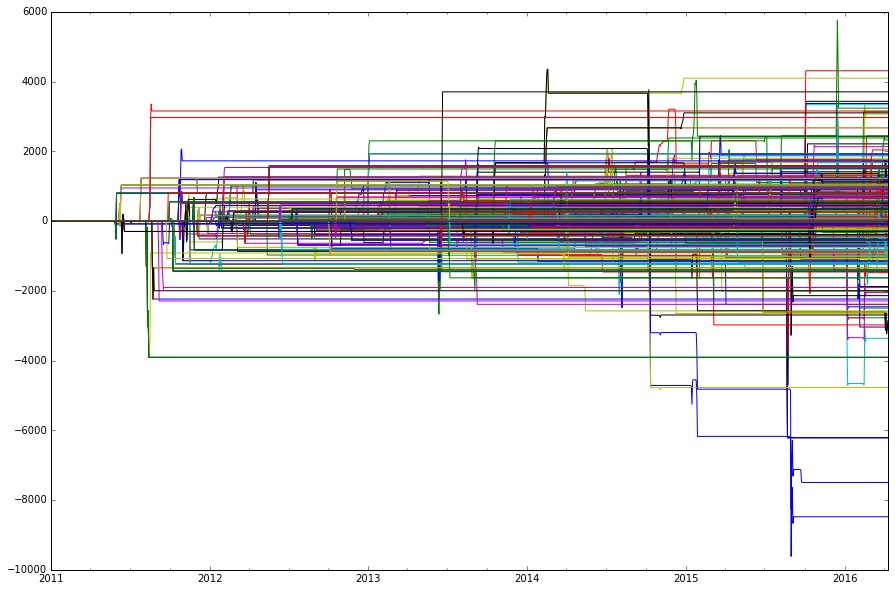

In [25]:
smgr.swarm_picked.plot(legend=False)

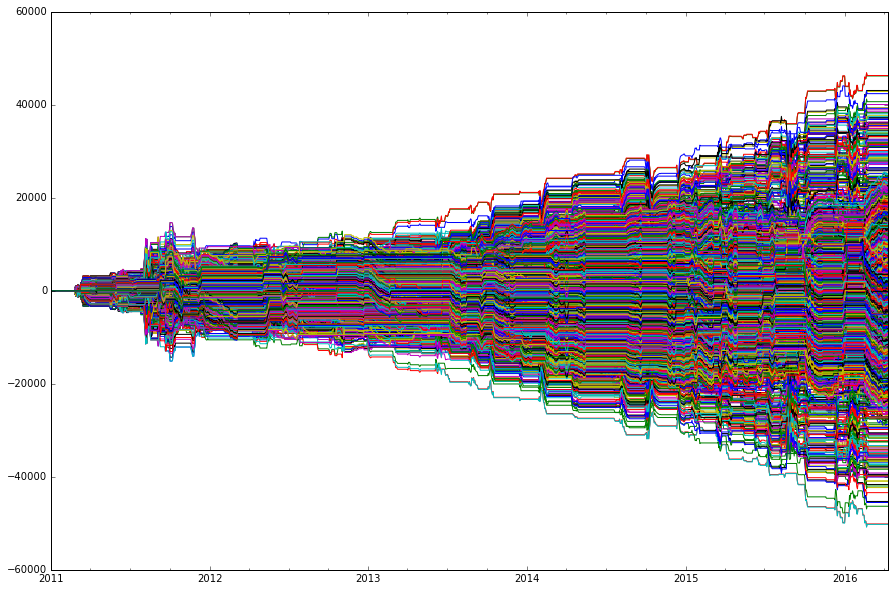

In [26]:
smgr.swarm.plot(legend=False)

## Exo information

In [ ]:
smgr.strategy.exoinfo.exo_info

In [ ]:
smgr.strategy.exoinfo.data.exo.plot()

### Global filter information

In [ ]:
title(smgr.global_filter_data['name'])
smgr.global_filter_data['values'].plot(label='Global filter')
smgr.swarm_avg.plot(label='Average swarm equity');

In [ ]:
smgr.global_filter.plot.area()

## Costs information (per 1-exo unit)

In [ ]:
figsize(10,5)
smgr.strategy.costs.plot()

## Margin graphs

### EXO Margin (per 1 EXO unit)

In [ ]:
smgr.strategy.exoinfo.margin().plot()

### Average swarm margin

In [ ]:
(smgr.swarm_picked_margin).rolling(30).mean().plot()

In [ ]:
for i in range(1):
    print(i)